APPLICATION OF DEEP REINFORCEMENT LEARNING IN STOCK TRADING STRATEGIES


In [1]:
#PROBLEM STATEMENT:

# You are given the stock price till the (t-1)^th day and you need to predict whether the stock price would go up,down or would remain sideways on the t^th day,
# So the current state is the close price list till the (t-1)-day  and the number of stocks we have purchased on this time stamp
# Your action would be:
# You should buy the stock(which means we predict the stock price to go up)
# You should sell the stock(which means we predict the stock price to go down)
# You should hold on the position (which means do nothing)
# First of all there a few variables
# MAX_TRANSACTIONS = k, maximum number of time we can do a buy after a selling
# TOTAL_MONEY = k2 , total money that we have in cash(virtual ) 
# CURRENT_STOCKS_BOUGHT = k3 , the number of stocks we have bought currently
# CURRENT_TRANSACTION_COUNT = k4, number of buys done before selling - You can only do the buy if CURRENT_TRANSACTION_COUNT<MAX_TRANSACTIONS
# Whenever you do a buy the amount with which you buy the stocks are x= TOTAL_MONEY/(MAX_TRANSACTIONS- CURRENT_TRANSACTION_COUNT)  and the number of stocks bought in this buy signal = x/STOCK_PRICE at that moment.
# Whenever you do sell just increase your TOTAL_MONEY by CURRENT_STOCKS_BOUGHT*STOCK_PRICE and do the CURRENT_TRANSACTION_COUNT=0
# Now when to do a buy or when to do the sell:
# Do the buy whenever there is a buy signal and when CURRENT_TRANSACTION_COUNT<MAX_TRANSACTIONS
# When there is a sell signal from DQN , just sell any stocks if you had purchased if any
# When there is a hold signal , do nothing
# Reward: It is the profit or the loss that happens in any transactions
# DataSet: Use the 2009 January-2017 December data for training and then use the 2018 January-2019 December data to do the test(and report the profits made in it)

#AMAZON STOCK  2007 to 2019 
# 2009 January-2017 December data for training
# jan 2018 to dec 2019 data for testing purpose

In [2]:
#importing all the libraries

In [3]:
import numpy as np  #for calculations
import pandas as pd  #for data import 
import matplotlib.pyplot as plt #for visualisation
import gym #for creating environment
import seaborn as sns #for visualisation
import time #for keeping track of execution time
import copy # for coping weights of neural network
import chainer #For creating neural network the syntax is same as pytorch now, it is also fused to pytorch
import chainer.functions as F
import chainer.links as L

In [4]:
#importing the data and divide it into train and split part

In [5]:
df=pd.read_csv("AMZN (1).csv") #using amazon daily data from yahoo finance

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-01-03,38.680000,39.060001,38.049999,38.700001,38.700001,12405100
1,2007-01-04,38.590000,39.139999,38.259998,38.900002,38.900002,6318400
2,2007-01-05,38.720001,38.790001,37.599998,38.369999,38.369999,6619700
3,2007-01-08,38.220001,38.310001,37.169998,37.500000,37.500000,6783000
4,2007-01-09,37.599998,38.060001,37.340000,37.779999,37.779999,5703000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3259 non-null   object 
 1   Open       3259 non-null   float64
 2   High       3259 non-null   float64
 3   Low        3259 non-null   float64
 4   Close      3259 non-null   float64
 5   Adj Close  3259 non-null   float64
 6   Volume     3259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 178.4+ KB


In [8]:
#nothing is missing

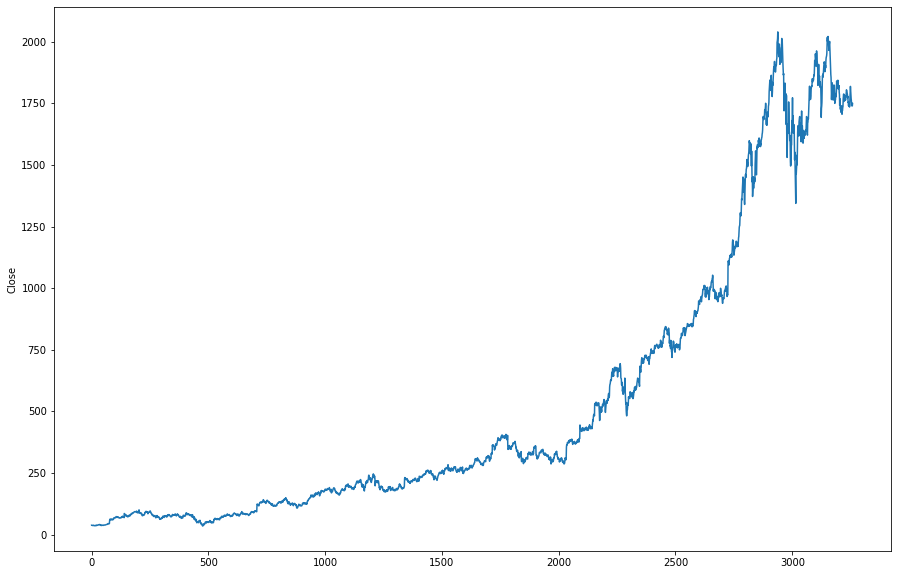

In [9]:
plt.figure(figsize=(15,10))
sns.lineplot(x=df.index,y="Close",data=df)

In [10]:
#splitting into train and test
train=df[df.index<2769]
test=df[df.index>=2769]
#at index 2769 , date is 2 jan 2018  

In [11]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-01-03,38.680000,39.060001,38.049999,38.700001,38.700001,12405100
1,2007-01-04,38.590000,39.139999,38.259998,38.900002,38.900002,6318400
2,2007-01-05,38.720001,38.790001,37.599998,38.369999,38.369999,6619700
3,2007-01-08,38.220001,38.310001,37.169998,37.500000,37.500000,6783000
4,2007-01-09,37.599998,38.060001,37.340000,37.779999,37.779999,5703000


In [12]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2769,2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500
2770,2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800
2771,2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100
2772,2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700
2773,2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500


In [13]:
#creating the environment
#inputs to the environment Data(train),Total_Amount,Max_tranction,history_length 

In [14]:
class environment(gym.Env):
    def __init__(self,data,Total_Amount,Max_transaction,history_length=100):
        self.data=data  #data of a stock
        self.total_Amount=Total_Amount #total amount of money we have
        self.Max_transaction=Max_transaction #max_transaction after between 2 sell actions
        self.history_length=history_length #amount of history of stock price difference we want to store 
        self.action_space=gym.spaces.Discrete(3) #gym action space
        self.reset() #reset the data when environment is called
    def reset(self): 
        self.t = 0  # for iterating the dataframe
        self.Total_Amount=self.total_Amount #total initial amount+profits
        self.current_stocks=[] #keep record of the current stocks
        self.done = False   #done bool for finished or not
        self.profits = 0  #total profits without no limit of money and max_transaction
                        # no use in our project just for experimentations
        self.calculated_profits=0 # profit with all the limits told in the problem statement
                        # at last we can also calculate by final total-initial total
        self.positions = [] #Total positions in the market we have , length of this can give current transaction
        self.position_value = 0 # after our action taken and all the parameters calculated , using that day close price we calculate position value and give input to the neural network
        self.history = [0 for i in range(self.history_length)] #list for storing the history, we are going to maintain it like a queue
        return [self.position_value] + self.history #return list with postion value and history for input to neural network
    def step(self,action):
        
        reward=0 #variable for storing reward 
        
        #actionspace : 0=hold,1=buy,2=sell
        
        if (action==1):
            if(len(self.positions)<=self.Max_transaction):
                self.positions.append(self.data.iloc[self.t, :]['Close'])
                
                self.current_stocks.append((self.Total_Amount)/((self.Max_transaction-len(self.positions))*self.data.iloc[self.t, :]['Close']))
                self.Total_Amount=self.Total_Amount-(self.Total_Amount)/((self.Max_transaction-len(self.positions)))
         # AS action 1 is buy we append the close price to the position list if the length of positions is less than Max_transaction
        #lenth of position is same as current transaction
        #We also calculated how much stocks we can buy in this action using the formula suggested in the problem statement
        # Append it to the list of current_stocks
        
        elif (action==2):                                          
            if len(self.positions) == 0:
                reward = -1 #punishing for 2 sells having no buy order between them  as we don't have anything to sell
            else:
                profits = 0 #with no limits 
                new_profit=0 #with all the limits of problem statement
                
                for i in range(len(self.positions)):
                    new_profit += (self.data.iloc[self.t, :]['Close'] - self.positions[i])*self.current_stocks[i]
                    #calculating profits on selling with all the postions we have
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                   
                reward += new_profit
                self.profits += profits
                self.calculated_profits+=new_profit
                self.Total_Amount=self.Total_Amount+self.data.iloc[self.t, :]['Close']*sum(self.current_stocks)
                #calculate total_amount after the selling of all position we have
                self.positions = []
                #removing all positions and current stokes as we sell them
                self.current_stocks=[]                                     
        # set for next time
        self.t += 1
        # as we have taken action for that day now we can use its close  for calculating next 
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        #poping the element which stored first like queue 
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        # appending the price difference of this day
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #clipping the reward to 1 or -1 
        #if we hold or buy we have reward zero
        # if we sell profit >0 results in reward of 1 and profit<0 result in -1
        return [self.position_value] + self.history, reward, self.done
    # returning in same form like gym except the info 

In [15]:
#Taking Total_Amount =1000000 Max_Transactions=100
#creating environment for training data

env=environment(train,1000000,100)

In [16]:
#lets see few attributes of our env
print(env.action_space)
print(env.Total_Amount)
print(env.Max_transaction)


Discrete(3)
1000000
100


In [17]:
keep_all_action=[]
def train_double_deep_q_network(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )
        #creating 3 layered neural network
        # chainer is similar to pytorch 
        # Linear means all the layers are fully connected
        #our first layer is of input size which we give is history length +1(positional value)
        #second layer is hidden layer with 100 nodes
        #outlayer is obvious consists of 3 nodes to ouput the q values for the 3 action we have in our action space
        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y
        #so the activation function used is rectified linear unit between these layers 
        # I aslo play around with these best I got is takin both relu
        def reset(self):
            self.zerograds()
        # initiating all the weights to zer0
    #After making Q_network class We make Two neural network
    # We try to minimise the loss between Q_value given by our network and Q_max from bellman optimality equation
    #but we also don;t know the bellman optimal Q value 
    # using 2nd network we calculate that
    Q = Q_Network(input_size=env.history_length+1, hidden_size=100, output_size=3)
    #first network
    Q_ast = copy.deepcopy(Q)
    #2nd network
    optimizer = chainer.optimizers.Adam()
    #using Adam optimiser
    optimizer.setup(Q)

    epoch_num = 20 #toatl epoch over the training data
    step_max = len(env.data)-1
    memory_size = 200 #size of Replay memory storing our experiences
    batch_size = 50 
    epsilon = 1.0 #max_epsilon
    epsilon_decrease = 1e-3 #epsilon decay rate
    epsilon_min = 0.1 #min epsilon
    start_reduce_epsilon = 200 #start reducing epsilon after 200 steps
    train_freq = 10 #frequency at which we train our network
    update_q_freq = 20 #frequency at which we copy the weights of our first network into other
    gamma = 0.97  #discount factor
    show_log_freq = 1 #frequency at which we show our log
    #may be changed if the log became large

    memory = [] #replay memory
    total_step = 0 
    total_rewards = [] #keep tracks of rewards obtained by the action
    total_losses = [] #loss from the loss function defined later

    start = time.time() #keep track of time
    for epoch in range(epoch_num):

        pobs = env.reset() 
       
        #At starting reseting the environment 
        #pobs have list of zeors 
        step = 0
        done = False
        #done to check epoch finishes or not
        total_reward = 0
        #total reward for every epoch
        total_loss = 0
        #loss by loss function

        while not done and step < step_max:

            
            pact = np.random.randint(3)
            #Taking any random action  
            #we only take this action if randomly generated number is less than epsilon (epsilon greedy strategy)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
               
                pact = np.argmax(pact.data)
                

            # append to the action list
            keep_all_action.append(pact)
#             )
            obs, reward, done = env.step(pact)
            #taking a step using the step environment funtion which return list +reward for that action+done
        
            # add this to memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)
            
            # train or update q
            #We train our network at our training frequency
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    #shuffing the memory so that corealtion between consecutive experiences don't captured by our network results in better learning
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    #In next step batch size act like step we use in range funtions 
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        #selecting the batch 
                        # as we know the batch has 5 columnsas we appended in the memory list (pobs,pact,reward, obs,done)
                        #it is same as storing (St,Action,reward,S(t+1),done)
                        #below we are selecting different columns to work with
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                       #Using Our first network We calculate Q value of all three action and take index of max Q value 
                        indices = np.argmax(q.data, axis=1)
                        #using 2nd we also estimate the Q_values 
                        maxqs = Q_ast(b_obs).data
                        
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            
                        Q.reset()
                        #As defined the loss function is square of difference between the 2 Q values 
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data #storing the total loss
                        loss.backward() #minimising the loss
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)
                    #at update_q_frequency we update the weights of 1st network with 2nd one
                    #we don't update every time as they don't converge than resuting in bad results
            # epsilon decreasing after few steps linearly
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1
        #appending reward and loss to see at the epoch end
        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        #showing the log after every epoch
        log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
        log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
        elapsed_time = time.time()-start #time to complete that epoch
        print('\t'.join(map(str, [epoch+1, total_step, log_reward, log_loss, elapsed_time])))
        #printing the epoch number total step in each epoch, reward obtained, Total loss from neural network, time taken by it
        start = time.time()
            
    return Q, total_losses, total_rewards
#return network, loss and reward

In [18]:
Q, total_losses, total_rewards = train_double_deep_q_network(env)#training our network 

1	2768	-281.0	607.633637920022	10.584585666656494
2	5536	-42.0	99.41248110681772	13.087390661239624
3	8304	79.0	110.9185795430094	15.392655849456787
4	11072	102.0	80.26714731007814	16.441572666168213
5	13840	-36.0	20.488780030282214	12.876848220825195
6	16608	-4.0	16.72856147494167	13.647215843200684
7	19376	101.0	23.708366319653578	17.200809240341187
8	22144	103.0	22.507205125468317	18.69883131980896
9	24912	31.0	14.310412313468987	14.69767689704895
10	27680	124.0	27.30244692787528	15.69750690460205
11	30448	-6.0	18.485708538646577	13.913450479507446
12	33216	92.0	17.65924117976101	14.468338012695312
13	35984	-27.0	7.182740275857213	13.519613981246948
14	38752	99.0	8.721305406899774	14.287423849105835
15	41520	130.0	14.070941724232398	17.003628253936768
16	44288	43.0	9.774741641274886	18.35339093208313
17	47056	116.0	12.301551807424403	16.860354900360107
18	49824	170.0	15.152793582194136	15.742996454238892
19	52592	209.0	10.910171490482753	13.93871784210205
20	55360	53.0	7.18320791811

In [19]:
env.Total_Amount #total amounts with profits

1063911.26956673

In [20]:
env.current_stocks
#after all actions how many many stocks we have

[]

In [21]:
#Lets see the action taken by our agent


In [22]:

#All actions from all epochs
count0=0
count1=0
count2=0
print("Total action=",len(keep_all_action))
for i in keep_all_action:
    if(i==0):
        count0=count0+1
    elif (i==1):
        count1=count1+1
    else:
        count2=count2+1
print("Hold=",count0)
print("Buy=",count1)
print("Sell=",count2)

Total action= 55360
Hold= 28848
Buy= 19836
Sell= 6676


In [23]:
#consecutive buys made by our agent between 2 sell
max_count=0
count=0
counti=[]
for i in keep_all_action:
    
    if(i==1):
        count=count+1
    if(i==2):
        counti.append(count)
        count=0
        
    if(count>max_count):
        max_count=count
print(max_count)

94


In [24]:
#Now lets test the agent on test data

In [35]:
act=[]
def Test_our_agent(train_env, test_env, Q):
    
    # train
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)#taking the action with max q values 
        test_acts.append(pact)
        act.append(pact)
            
        obs, reward, done = test_env.step(pact) 
        test_rewards.append(reward)

        pobs = obs
    return test_rewards
        





In [36]:
test_env=environment(test,1000000,47)
l1=Test_our_agent(env,test_env,Q) #testing our environment
#now the question is how much max_transaction we take
#we should take much less than training as training data is pretty large than testing data
#if we take large max_transaction most of our amount remain unused 

In [37]:
test_env.total_Amount

1000000

In [38]:
test_env.Total_Amount
# Total amounts after training (initial +profits)

933575.6770620357

In [46]:
#its seems we make lose but here is a twist we doesn't take account the current stocks we have


In [47]:
test_env.current_stocks

[13.672010073772814,
 13.509840935831157,
 13.64270341338531,
 13.95349652611932,
 14.115520579166173,
 14.025908490487858,
 14.042663851529907,
 14.12582812094228]

In [48]:
#just assume we also sell these stocks at last with price of last day 
#the last day prife is
test[test.index==max(test.index)]


,Date,Open,High,Low,Close,Adj Close,Volume
3258,2019-12-11,1741.670044,1750.0,1735.709961,1748.719971,1748.719971,2097600


In [50]:
#so the last day price is 1748
print(test_env.positions)
1748.71*sum(test_env.current_stocks)

[1796.939941, 1818.5100100000002, 1800.800049, 1760.689941, 1740.47998, 1751.5999760000002, 1749.5100100000002, 1739.209961]


194260.64750079229

In [51]:
#so the total profit is(in percentage)
((test_env.Total_Amount+1748.71*sum(test_env.current_stocks))-test_env.total_Amount)*100/test_env.total_Amount
#I run it many time the profit ranges from 5% to 20% 

12.783632456282806

In [52]:
max_count=0
count=0
counti=[]
for i in act:
    
    if(i==1):
        count=count+1
    if(i==2):
        counti.append(count)
        count=0
        
    if(count>max_count):
        max_count=count
print(max_count)


46


In [53]:
#lets see the amount used using our formula given in the problem statement taking 47 transactions
price=[1000000]
for i in range(47):
    price.append(price[i]-price[i]/(47-i))

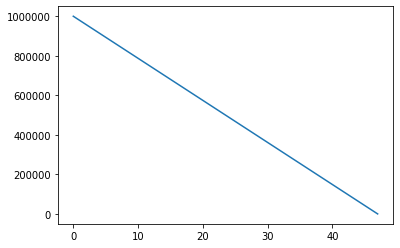

In [54]:
plt.plot(price)

In [55]:
#lets plot our actions of our test data

In [56]:
len(test)

490

In [57]:
len(act)

489

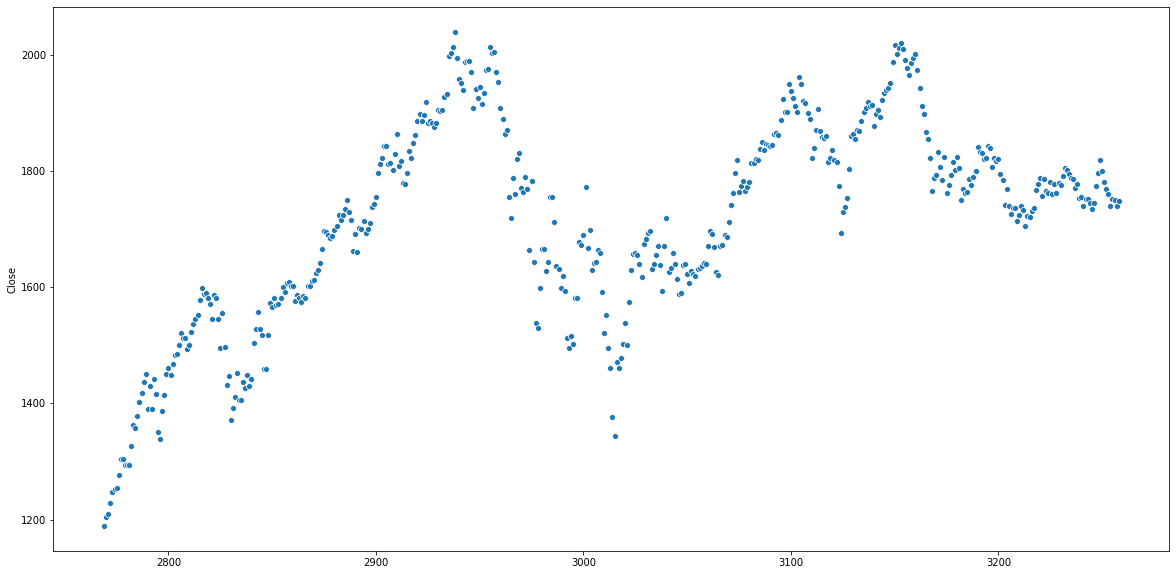

In [58]:

plt.figure(figsize=(20,10))
sns.scatterplot(x=test.index, y="Close",data=test)

In [59]:
test.drop(index=3258,axis=0,inplace=True)
len(test)

C:\Users\manish\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


489

In [60]:
test["Action"]=act

C:\Users\manish\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


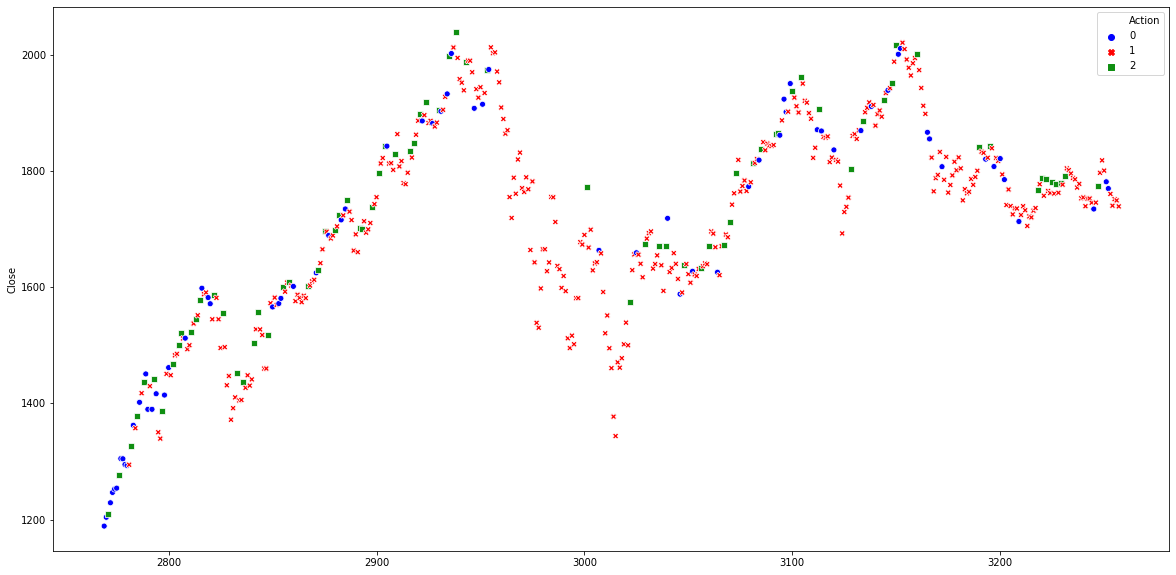

In [61]:
plt.figure(figsize=(20,10))

pal=sns.set_palette(sns.color_palette(["#108f87","#ff0000","#000000"]))
sns.scatterplot(x=test.index, y="Close",data=test,hue="Action",palette=["#0000ff","#ff0000","#108f12"],style="Action")

In [62]:
#above graph is scatterplot with the action we take on that point 
#BLUE DOTS: HOLD
#RED CROSS: BUY
#GREEN SQUARES: SELL